In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def print_separator(sep, num, msg):
  print("\n")
  print(sep * num)
  print(f"{msg}")
  print(sep * num)

In [3]:
def unique_values(df, column):
    print_separator('*', 50, "Unique Values")
    unique_vals = df[column].unique()
    try:
        sorted = np.sort(unique_vals)
        print('Sorting succesfull')
        display(list(sorted))
    except TypeError as error:
        print(f'Sorting failed: {error}')
        display(list(unique_vals))

In [4]:
def exploring_data(df, column):
    print_separator('-', 50, f'Checking column #{column}')
    unique_values(df, column)
    print_separator('*', 50, "Value counts")
    display(dict(df[column].value_counts(dropna=False)))

In [5]:
def cast_to_type(df, column, type):
  try:
    df[column].astype(type)
    print(f"Casting to {type} was successful")
  except ValueError as error:
    print(f"Could not cast to {type}: {error}")

In [6]:
#exploring_data(shark_attacks, 'Unnamed: 22')
#exploring_data(shark_attacks, 'Unnamed: 23')

#Columns Unnamed:23 and Unnamed: 22 contain mainly nan. Dropping from dataframe for irrelevance.
def clean_data():
    data = pd.read_csv('attacks.csv', encoding='cp1252')
    data = data.drop(columns=['Unnamed: 22', 'Unnamed: 23'])
    return data

In [7]:
from collections import Counter

def count_activity(df, column):    
    c = Counter()
    df[column] = df[column].str.lower()
    df[column].str.split().apply(c.update)
    return c.most_common()

In [8]:
shark_attacks = pd.read_csv('attacks.csv', encoding='cp1252')
shark_attacks.iloc[0:2].T
shark_attacks.info() #The two columns 'Unnamed' contains only 3 entries in total, highest entry count is 8702 - df runs to 25723
shark_attacks['Unnamed: 22'].unique() #nonsense entry
shark_attacks['Unnamed: 23'].unique() #nonsense entry

#dropping the two columns and rows with only NaN
shark_attacks.dropna(how = 'all', inplace = True)
shark_attacks.drop(columns=['Unnamed: 22', 'Unnamed: 23'], axis=1, inplace=True)

more_20 = shark_attacks.loc[shark_attacks.isnull().sum(axis=1) > 19] #checking for rows with only entries in two columns or less
more_20.info() #only a few entries in Case Number and original order -> not relevant(drop)
shark_attacks.drop(more_20.index, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25723 entries, 0 to 25722
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Case Number             8702 non-null   object 
 1   Date                    6302 non-null   object 
 2   Year                    6300 non-null   float64
 3   Type                    6298 non-null   object 
 4   Country                 6252 non-null   object 
 5   Area                    5847 non-null   object 
 6   Location                5762 non-null   object 
 7   Activity                5758 non-null   object 
 8   Name                    6092 non-null   object 
 9   Sex                     5737 non-null   object 
 10  Age                     3471 non-null   object 
 11  Injury                  6274 non-null   object 
 12  Fatal (Y/N)             5763 non-null   object 
 13  Time                    2948 non-null   object 
 14  Species                 3464 non-null 

Assumption / Bias: 
1. Name of Shark is in front of the word 'Shark' atleast once.
2. Removed cases where shark involvement is questionable
3. If the name of shark contains two seperate words its shortend to the second word
4. The first mentioned name of shark is extracted if there is two shark mentioned
5. If shark names has to be guessed it will be marked as 'Unknown Shark' (ex: blacktipped is prolly blacktip shark)
6. Assumed that Zambesi means Zambezi shark. (Its also a bull shark but not renamed to bullshark)
**What are the most dangerous types of sharks to humans?** 

White shark, Tiger Shark, Bull shark, Blacktip, Nurse

<AxesSubplot:title={'center':'The type of shark most likely to attack humans'}, xlabel='Shark Name', ylabel='Percentage'>

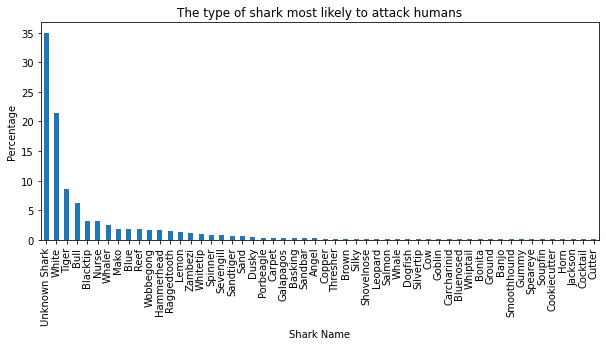

In [45]:
import re

shark_names = shark_attacks.copy()
shark_names.rename(columns={'Species ': 'Species'}, inplace=True)

#Selecting only relevant data with case number
shark_names = shark_names[['Case Number', 'Species']].copy()
shark_names.dropna(subset=['Species'], inplace=True)

#dropping invalid, 'questionable shark involvement', 
shark_names.drop(shark_names.loc[shark_names['Species'].str.contains('involvement|invalid|Questionable', flags=re.IGNORECASE)].index, inplace=True)

#remove all non-alphabetic letters, extract name in front of shark
shark_names['Only Alpha'] = shark_names['Species'].str.replace('[^a-zA-Z\s]', '', regex=True)
shark_names.loc[shark_names['Species'].str.contains('7-gill')] = 'Sevengill'
shark_names.loc[shark_names['Species'].str.contains('Zambesi')] = 'Zambezi'
shark_names['Only Alpha'] = shark_names['Only Alpha'].str.title()
shark_names['Extract Name'] = shark_names['Only Alpha'].str.extract('(\S+(?=\s+shark|Shark))', flags=re.IGNORECASE)

#clean out extracted names
shark_names['Extract Name'].loc[shark_names['Extract Name'].str.len() < 3] = 'Unknown Shark'
unknown_sharks = ["Small", "Juvenile", "Foot", 'Metre', 'Tipped', "Greycolored", "Captive", "Colored", 
"Finned", 'Young', 'Unidentified', 'Grey',  'Female', 'Two', 'Gaffed', 'Gray', 'Dog','Blackfin', 'For', 
'Browncolored', 'Red', 'Hooked', 'Larger', 'Involve', 'Several', 'Little', 'Large', 'The', 'Saw', 'From', 'Blacktipped']
shark_names['Extract Name'].replace(unknown_sharks, 'Unknown Shark', inplace=True)

#Second extract including all names without shark following its name
extract_pattern = '|'.join(list(shark_names['Extract Name'].dropna().unique()))
shark_names['Shark Name'] = shark_names['Only Alpha'].str.extract(fr'\b({ extract_pattern })\b', expand=False)
shark_names['Shark Name'].fillna('Unknown Shark', inplace=True)

#solve it with groupby
perc_shark = shark_names.groupby(['Shark Name']).size() / shark_names.groupby(['Shark Name']).size().sum() * 100
perc_shark.sort_values(inplace=True, ascending=False)
perc_shark.plot(kind='bar', rot=90, figsize=(10,4), title="The type of shark most likely to attack humans", ylabel='Percentage')

Assumption / Bias: 
1. There are no human aged >= 1000
2. Adults are 18 or older
3. Only one age per cell 

**are children more likely to be attacked by sharks?**

No, Adults are more likely to be attacked.

In [10]:
df_age = clean_data()[['Case Number', 'Age']].copy()
df_age['Normal'] = df_age['Age'].loc[(df_age['Age'].str.len() < 4)]

#casting everything to float
df_age['Normal'].replace({'40s': 40, '20s': 20, '60s':60, '30s': 30, '50s': 50, r'^\s*$': np.nan, '6½': 6.5, '20?':20, '>50':50, 'X': np.nan, 'F': np.nan}, inplace=True, regex = True)
#cast_to_type(df_age, 'Normal', float)
df_age['Normal'] = df_age['Normal'].astype(float)
# exploring_data(df_age, 'Normal')

#divide data into child or adult
df_age['Age Group'] = np.select([df_age['Normal'] >=18, df_age['Normal'] <18], ['Adult', 'Child'])
Child = pd.DataFrame(df_age['Age Group'].value_counts())

display(Child[1:])

,Age Group
Adult,2560
Child,833


Assumption / Bias: 

Decision: 
1. Categorizing [Boat, Boatomg, Boating, 'Sea Disaster', 'Questionable', 'Invalid'] as third category \
     * According to https://en.wikipedia.org/wiki/Shark_attack sea disaster is not categorize as provoked or unprovoked but as a seperate category. \
     * Boating or anything with boats should actually be subcategorized as 'provoked or unprovoked' (https://vacationwildlife.com/sharks-attack-boats/) \
2. Injury is not used in analyse.

**are shark attacks where sharks were provoked more or less dangerous?**

Unprovoked attack are more dangerous with vastly higher chance for fatality, while provoked barely ever leads to death.

In [11]:
df_provoke = clean_data()[['Type', 'Injury', 'Fatal (Y/N)']].copy()
df_nona = df_provoke.loc[(df_provoke['Type'] == 'Unprovoked') | (df_provoke['Type'] == 'Provoked')].copy()
df_nona['Fatal (Y/N)'].replace({np.nan:None, 'UNKNOWN':None, ' N':'N', 'N ':'N', 'y': 'Y', 'M':None, '2017':None }, inplace=True)
exploring_data(df_nona, 'Type')



--------------------------------------------------
Checking column #Type
--------------------------------------------------


**************************************************
Unique Values
**************************************************
Sorting succesfull


['Provoked', 'Unprovoked']



**************************************************
Value counts
**************************************************


{'Unprovoked': 4595, 'Provoked': 574}

A

In [12]:
df_new = clean_data()[['Activity', 'Type']].copy()
df_act_pro = df_new.loc[df_new['Type'] == 'Provoked'].copy()
df_act_pro.dropna(subset=['Activity'], inplace=True)
count_dict = dict(count_activity(df_act_pro, 'Activity'))
filtered_dict = {k:v for k,v in count_dict.items() if 'ing' in k }
del filtered_dict['attempting']
del filtered_dict['dinghy']
del filtered_dict['landing']
del filtered_dict['inspecting']
del filtered_dict['bringing']
display(filtered_dict)

value_dict = dict(zip(list(filtered_dict.keys()), list(filtered_dict.keys())))
value_dict['spearing'] = 'fishing'
value_dict['lasso'] = 'lassoing shark'
value_dict['kill'] = 'killing shark'
value_dict['hoist'] = 'hoisting shark'
value_dict['net'] = 'netting'
value_dict['grab'] = 'grabbing shark'
value_dict['foot'] = 'foot in shark'
value_dict['harpooned'] = 'spear'

for key, value in value_dict.items():
    df_act_pro['Activity'].loc[df_act_pro['Activity'].str.contains(key)] = value

# df_act_pro['Activity'].loc[df_act_pro.groupby("Activity")['Activity'].transform('size') < 2] = 'Other'
exploring_data(df_act_pro, 'Activity')


{'fishing': 242,
 'spearfishing': 59,
 'diving': 38,
 'fishing,': 15,
 'surfing': 12,
 'swimming': 11,
 'feeding': 9,
 'wading': 8,
 'removing': 8,
 'standing': 8,
 'snorkeling': 5,
 'filming': 5,
 'spearfishing,': 5,
 'netting': 5,
 'freediving': 4,
 'hauling': 4,
 'touching': 3,
 'diving,': 3,
 'holding': 3,
 'tagging': 3,
 'carrying': 3,
 'finning': 3,
 'pulling': 3,
 'helping': 3,
 'collecting': 3,
 'teasing': 2,
 'petting': 2,
 'canoeing': 2,
 'standing,': 2,
 'sailing': 2,
 'killing': 2,
 'wading,': 2,
 'moving': 2,
 'skindiving': 2,
 'gaffing': 2,
 'hunting': 2,
 'spearing': 2,
 'testing': 2,
 'watching': 2,
 'dragging': 2,
 'towing': 2,
 'hoisting': 2,
 'shooting': 2,
 'grabbing': 1,
 'lobstering': 1,
 'measuring': 1,
 'boarding': 1,
 'reviving': 1,
 'kissing': 1,
 'walking,': 1,
 'surfing,': 1,
 'conducting': 1,
 'returning': 1,
 'meshing': 1,
 'force-feeding': 1,
 'surf-fishing': 1,
 'sight-seeing': 1,
 'picking': 1,
 'splashing': 1,
 'clamming': 1,
 'catching': 1,
 'rowing':



--------------------------------------------------
Checking column #Activity
--------------------------------------------------


**************************************************
Unique Values
**************************************************
Sorting succesfull


C:\Users\Mandy\AppData\Local\Temp\ipykernel_8976\1987777294.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_act_pro['Activity'].loc[df_act_pro['Activity'].str.contains(key)] = value


[' ',
 "accidentally stood on hooked shark's tail before attempting to gut it ",
 'angling',
 'attempting to anesthetize shark',
 'attempting to drag hooked shark ashore by its tail',
 'attempting to drive shark from area',
 'attempting to rescue an injured & beached shark',
 'attempting to ride a shark',
 'boarding',
 'boating',
 'bring',
 'canoeing',
 'carrying',
 'catching',
 'chasing',
 'clamming',
 'cleaning',
 'collecting',
 'conducting',
 'cruising',
 'cutting',
 'diving',
 'dragging',
 'examining',
 'feeding',
 'feeling',
 'fell off surf ski',
 'fell onto dead shark',
 'filming',
 'finning',
 'fishing',
 'floating',
 'foot in shark',
 'gaffing',
 'grabbing shark',
 'harassing',
 'hauling',
 'helping',
 'hoisting shark',
 'holding',
 'hunting',
 'in rubber dinghy with captain eddie rickenbacker for 21 days. ',
 'inspecting teeth of supposedly dead (hooked & shot) shark',
 'jumped off surfboard & landed on the shark',
 'killing shark',
 'landing hooked shark in boat',
 'lassoing 



**************************************************
Value counts
**************************************************


{'fishing': 324,
 'diving': 46,
 'surfing': 13,
 'swimming': 12,
 'standing': 9,
 'moving': 8,
 'wading': 8,
 'feeding': 7,
 'netting': 5,
 'snorkeling': 5,
 'killing shark': 4,
 'tagging': 3,
 'helping': 3,
 'collecting': 3,
 'touching': 3,
 'finning': 3,
 'holding': 2,
 'dragging': 2,
 'foot in shark': 2,
 'hauling': 2,
 'pulling': 2,
 'shooting': 2,
 'gaffing': 2,
 'filming': 2,
 'hunting': 2,
 'teasing': 2,
 'sailing': 2,
 'canoeing': 2,
 'grabbing shark': 2,
 'petting': 2,
 'lassoing shark': 2,
 'carrying': 2,
 'examining': 1,
 'watching': 1,
 'bring': 1,
 'underwater photography': 1,
 'attempting to ride a shark': 1,
 'in rubber dinghy with captain eddie rickenbacker for 21 days. ': 1,
 'sculling': 1,
 'fell off surf ski': 1,
 'cutting': 1,
 'surf-skiing': 1,
 'fell onto dead shark': 1,
 'paddleskiing': 1,
 'cruising': 1,
 'landing hooked shark in boat': 1,
 'boating': 1,
 'feeling': 1,
 'hoisting shark': 1,
 'spear': 1,
 'stuffing': 1,
 ' ': 1,
 'angling': 1,
 'restraining': 1,
